## Split CIFAR-10 into training, validation, and testing sets

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import PIL

train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1), resample=PIL.Image.BILINEAR),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_set, val_set = torch.utils.data.random_split(dataset, [40000, 10000])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=False, num_workers=8)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=False, num_workers=8)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

/tmp/.longkhan/ipykernel_5161/740932320.py:8: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  transforms.RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1), resample=PIL.Image.BILINEAR),
/userhome/cs2/longkhan/anaconda3/envs/study/lib/python3.10/site-packages/torchvision/transforms/transforms.py:1427: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed in 0.14. Please use 'interpolation' instead.
  warnings.warn(


Files already downloaded and verified


/userhome/cs2/longkhan/anaconda3/envs/study/lib/python3.10/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


## Visualize image for each class

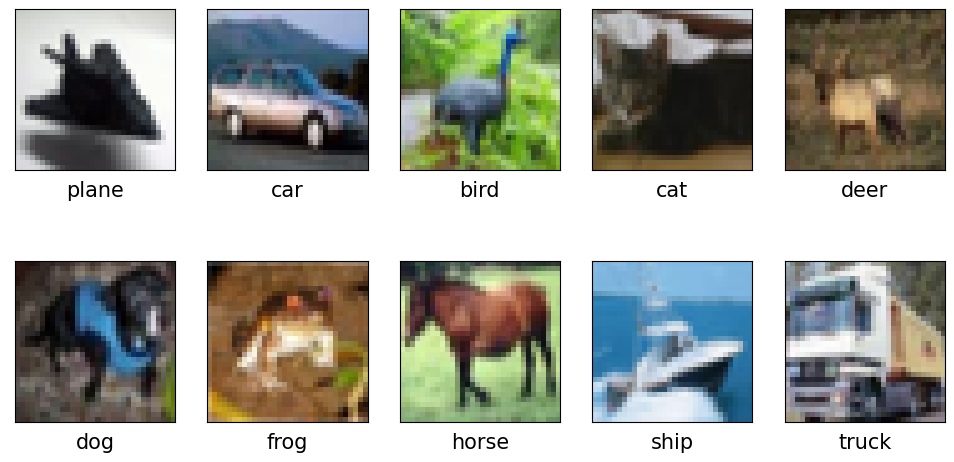

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# visualize training image for each class
sample_images = [dataset.data[np.asarray(dataset.targets) == label][0] for label in range(10)]
# show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(classes[i], fontsize=15)
    axis.imshow(sample_images[i])
    i += 1

## Define CNN architecture

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn.parameter import Parameter
import torchvision

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)


class LP_ReLU2(nn.Module):
    
    def __init__(self, in_features, alpha = None):
        '''
        Initialization.
        INPUT:
            - in_features: shape of the input
            - aplha: trainable parameter
            aplha is initialized with zero value by default
        '''
        super(LP_ReLU2,self).__init__()
        self.in_features = in_features

        # initialize alpha
        if alpha == None:
            self.alpha = Parameter(torch.tensor(6.0)) # create a tensor out of alpha
        else:
            self.alpha = Parameter(torch.tensor(alpha)) # create a tensor out of alpha

        self.alpha.requiresGrad = True # set requiresGrad to true!

    def forward(self, x):
        '''
        Forward pass of the function.
        Applies the function to the input elementwise.
        '''
        
        threshold0 = torch.zeros(x.shape)
        threshold0 = threshold0.to(device)
        x1 = torch.where(x < threshold0, threshold0, x)
        
        threshold1 = torch.ones(x1.shape)
        threshold1 = threshold1.to(device)
        threshold1 = threshold1 * (self.alpha)
        x2 = torch.where(x1 < threshold1, x1, threshold1)

        threshold2 = torch.ones(x2.shape)
        threshold2 = threshold2.to(device)
        threshold2 = threshold2 * (self.alpha)
        threshold2 = threshold2.to(device)
        x3 = torch.where(x2 > threshold2, 0.05*(x2-threshold2)+threshold2, x2)

        return x3
    
# Build the ResNet50 model
def get_model():
    model = torchvision.models.resnet50(False)
    model.fc = nn.Linear(2048, 10)

    # change activation function
    model.relu = LP_ReLU2(64)
    model.layer1[0].relu = LP_ReLU2(256)
    model.layer1[1].relu = LP_ReLU2(256)
    model.layer1[2].relu = LP_ReLU2(256)

    model.layer2[0].relu = LP_ReLU2(512)
    model.layer2[1].relu = LP_ReLU2(512)
    model.layer2[2].relu = LP_ReLU2(512)
    model.layer2[3].relu = LP_ReLU2(512)

    model.layer3[0].relu = LP_ReLU2(1024)
    model.layer3[1].relu = LP_ReLU2(1024)
    model.layer3[2].relu = LP_ReLU2(1024)
    model.layer3[3].relu = LP_ReLU2(1024)
    model.layer3[4].relu = LP_ReLU2(1024)
    model.layer3[5].relu = LP_ReLU2(1024)

    model.layer4[0].relu = LP_ReLU2(2048)
    model.layer4[1].relu = LP_ReLU2(2048)
    model.layer4[2].relu = LP_ReLU2(2048)

    return model

net = get_model()
net.to(device)

Device: cuda:0


/userhome/cs2/longkhan/anaconda3/envs/study/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): LP_ReLU2()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LP_ReLU2()
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


## Training

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, min_lr=0)

loss_hist, acc_hist = [], []
loss_hist_val, acc_hist_val = [], []

for epoch in range(30): # change epoch num here
  running_loss = 0.0
  correct = 0
  for data in train_loader:
    batch, labels = data
    batch, labels = batch.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = net(batch)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # compute training statistics
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum().item()
    running_loss += loss.item()

  avg_loss = running_loss / len(train_set)
  avg_acc = correct / len(train_set)
  loss_hist.append(avg_loss)
  acc_hist.append(avg_acc)

  # validation statistics
  net.eval()
  with torch.no_grad():
    loss_val = 0.0
    correct_val = 0
    for data in val_loader:
      batch, labels = data
      batch, labels = batch.to(device), labels.to(device)
      outputs = net(batch)
      loss = criterion(outputs, labels)
      _, predicted = torch.max(outputs, 1)
      correct_val += (predicted == labels).sum().item()
      loss_val += loss.item()
    avg_loss_val = loss_val / len(val_set)
    avg_acc_val = correct_val / len(val_set)
    loss_hist_val.append(avg_loss_val)
    acc_hist_val.append(avg_acc_val)
  net.train()

  scheduler.step(avg_loss_val)
  print('[epoch %d] loss: %.5f accuracy: %.4f val loss: %.5f val accuracy: %.4f' % (epoch + 1, avg_loss, avg_acc, avg_loss_val, avg_acc_val))




torch.save(net.state_dict(), 'checkpoint30II.pth')


[epoch 1] loss: 0.15569 accuracy: 0.2288 val loss: 0.12241 val accuracy: 0.3095
[epoch 2] loss: 0.12568 accuracy: 0.3236 val loss: 0.12078 val accuracy: 0.3622
[epoch 3] loss: 0.11712 accuracy: 0.3662 val loss: 0.11546 val accuracy: 0.3921
[epoch 4] loss: 0.11309 accuracy: 0.3884 val loss: 0.10653 val accuracy: 0.3946
[epoch 5] loss: 0.11163 accuracy: 0.3949 val loss: 0.10279 val accuracy: 0.4283
[epoch 6] loss: 0.11016 accuracy: 0.4066 val loss: 0.11277 val accuracy: 0.3631
[epoch 7] loss: 0.10691 accuracy: 0.4172 val loss: 0.09470 val accuracy: 0.4425
[epoch 8] loss: 0.10289 accuracy: 0.4172 val loss: 0.09239 val accuracy: 0.4626
[epoch 9] loss: 0.10104 accuracy: 0.4193 val loss: 0.10047 val accuracy: 0.4181
[epoch 10] loss: 0.09841 accuracy: 0.4336 val loss: 0.09454 val accuracy: 0.4530
[epoch 11] loss: 0.09611 accuracy: 0.4466 val loss: 0.08712 val accuracy: 0.4869
[epoch 12] loss: 0.09108 accuracy: 0.4726 val loss: 0.08649 val accuracy: 0.4937
[epoch 13] loss: 0.09058 accuracy: 0.

## Plotting training statistics

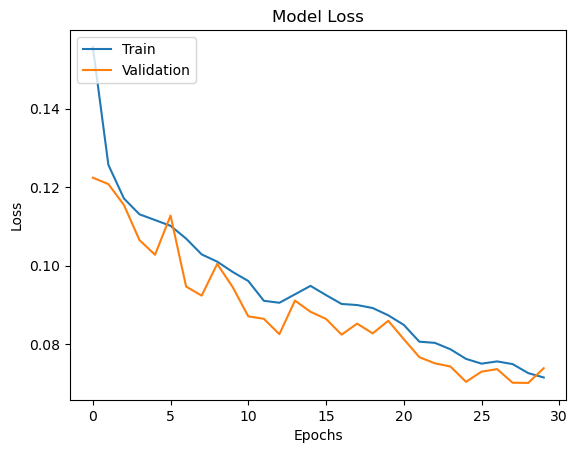

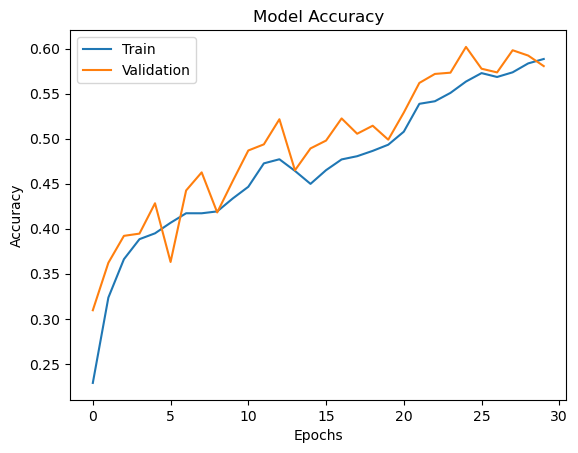

In [8]:
import matplotlib.pyplot as plt

legend = ['Train', 'Validation']
plt.plot(loss_hist)
plt.plot(loss_hist_val)
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(legend, loc='upper left')
plt.show()

legend = ['Train', 'Validation']
plt.plot(acc_hist)
plt.plot(acc_hist_val)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(legend, loc='upper left')
plt.show()

## Save the trained model

In [ ]:
# from google.colab import files

#torch.save(net.state_dict(), 'checkpoint.pth')
# download checkpoint file
# files.download('checkpoint.pth')

In [ ]:
#net.load_state_dict(torch.load('checkpoint.pth'))

## Testing

In [ ]:
'''pred_vec = []
correct = 0
net.eval()
with torch.no_grad():
    for data in test_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = net(batch)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        pred_vec.append(predicted)
    pred_vec = torch.cat(pred_vec)

print('Accuracy on the 10000 test images: %.2f %%' % (100 * correct / len(test_set)))'''

In [9]:
model = get_model()
model.load_state_dict(torch.load('checkpoint30II.pth'))
model = model.to(device)

/userhome/cs2/longkhan/anaconda3/envs/study/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
/userhome/cs2/longkhan/anaconda3/envs/study/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [14]:
import numpy as np

def get_test_data(data_name):
    test_data = np.load("./CIFAR-10-C/" + data_name + ".npy")
    test_label = np.load("./CIFAR-10-C/" + "labels.npy")
    test_data = test_data.astype('float32')
    test_data = test_data / 255.0
    # Reshape test data from (50000, 32, 32, 3) to (50000, 3, 32, 32)
    test_data = np.transpose(test_data, (0, 3, 1, 2))
    # Standardize the data with mean = (0.4914, 0.4822, 0.4465), var = (0.2023, 0.1994, 0.2010)
    test_data[:, 0, :, :] = (test_data[:, 0, :, :] - 0.4914) / 0.2023
    test_data[:, 1, :, :] = (test_data[:, 1, :, :] - 0.4822) / 0.1994
    test_data[:, 2, :, :] = (test_data[:, 2, :, :] - 0.4465) / 0.2010
    test_data = torch.from_numpy(test_data)
    test_label = torch.from_numpy(test_label)
    test_dataset = torch.utils.data.TensorDataset(test_data, test_label)
    return test_dataset

In [15]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset), test_loss

In [12]:
data_names=['natural','gaussian_noise','shot_noise','speckle_noise','impulse_noise','defocus_blur','gaussian_blur','motion_blur','zoom_blur','snow','fog','brightness','contrast','elastic_transform','pixelate','jpeg_compression','spatter','saturate','frost']

In [16]:
test_accs = []
test_losses = []
for data_name in data_names:
    if data_name == 'natural':
        dataset = torchvision.datasets.CIFAR10(root='./data', train=False,transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]))
    else:
        dataset = get_test_data(data_name)
    # Get the last 10000 images as test data
    lenth_of_dataset = len(dataset)
    test_dataset = torch.utils.data.Subset(dataset, range(lenth_of_dataset - 10000, lenth_of_dataset))
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)
    test_acc, test_loss = test(model, device, test_loader)
    test_accs.append(test_acc)
    test_losses.append(test_loss)

test_accs.append(np.mean(np.array(test_accs)))
data_names.append('avg')

Test set: Average loss: 2.2059, Accuracy: 3188/10000 (32%)
Test set: Average loss: 2.3915, Accuracy: 2804/10000 (28%)
Test set: Average loss: 2.3741, Accuracy: 2820/10000 (28%)
Test set: Average loss: 2.3873, Accuracy: 2826/10000 (28%)
Test set: Average loss: 2.5212, Accuracy: 2598/10000 (26%)
Test set: Average loss: 1.9004, Accuracy: 3804/10000 (38%)
Test set: Average loss: 1.8422, Accuracy: 3953/10000 (40%)
Test set: Average loss: 1.9434, Accuracy: 3712/10000 (37%)
Test set: Average loss: 1.9883, Accuracy: 3661/10000 (37%)
Test set: Average loss: 2.7622, Accuracy: 2268/10000 (23%)
Test set: Average loss: 2.1918, Accuracy: 3204/10000 (32%)
Test set: Average loss: 2.4758, Accuracy: 2622/10000 (26%)
Test set: Average loss: 2.4887, Accuracy: 2301/10000 (23%)
Test set: Average loss: 2.0943, Accuracy: 3398/10000 (34%)
Test set: Average loss: 2.0543, Accuracy: 3513/10000 (35%)
Test set: Average loss: 2.2222, Accuracy: 3163/10000 (32%)
Test set: Average loss: 2.4875, Accuracy: 2639/10000 (26

In [18]:
# Plot the test accuracy for different test data
import matplotlib
import matplotlib.pyplot as plt

matplotlib.use ('TkAgg')

print(data_names)
print(test_accs)

test_accs.pop(-1)
data_names.pop(-1)
plt.figure(figsize=(10, 10))
plt.bar(test_accs,np.array([0.3, 0.4, 0.5, 0.6]))
plt.title('Test accuracy for different test data')
plt.xlabel('Test data')
plt.ylabel('Test accuracy')
plt.xticks(rotation=90)
plt.show()


# Plot the test loss for different test data
plt.figure(figsize=(10, 10))
plt.bar(data_names, test_losses)
plt.title('Test loss for different test data')
plt.xlabel('Test data')
plt.ylabel('Test loss')
plt.xticks(rotation=90)
plt.show()

['natural', 'gaussian_noise', 'shot_noise', 'speckle_noise', 'impulse_noise', 'defocus_blur', 'gaussian_blur', 'motion_blur', 'zoom_blur', 'snow', 'fog', 'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 'spatter', 'saturate', 'frost', 'avg']
[0.3188, 0.2804, 0.282, 0.2826, 0.2598, 0.3804, 0.3953, 0.3712, 0.3661, 0.2268, 0.3204, 0.2622, 0.2301, 0.3398, 0.3513, 0.3163, 0.2639, 0.29, 0.2607, 0.3051631578947368]


ValueError: shape mismatch: objects cannot be broadcast to a single shape

In [ ]:

print(len(test_losses))

In [21]:
import pandas as pd

dict = {'name': data_names, 'accuracy' : test_accs, 'loss' : test_losses}
df = pd.DataFrame(dict)
df.to_csv('lp-relu2.csv')